In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils
import os

2023-04-20 21:41:14.703232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-20 21:41:17.284471: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-20 21:41:17.481716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 21:41:17.484300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 21:41:17.484319: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-20 21:41:17.518022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-20 

In [4]:
R = Runner(verbose=True, classifier='kunet3plus2d')

*** GP2 ***
Working directory: /tmp/tmpj5no_rleGP2
Verbose mode active!
KUNet3Plus2D: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f2e519b02b0>, <function binary_crossentropy at 0x7f2e51c23820>, [<function dice_coef at 0x7f2e51dc9b80>]
Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [16, 16, 16, 16]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 80


2023-04-20 21:41:17.615814: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 21:41:17.863573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 21:41:17.866047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 21:41:17.875777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet3plus_down0_0 (Conv2D)      (None, 512, 512, 16) 144         input_1[0][0]                    
__________________________________________________________________________________________________
unet3plus_down0_0_bn (BatchNorm (None, 512, 512, 16) 64          unet3plus_down0_0[0][0]          
__________________________________________________________________________________________________
unet3plus_down0_0_activation (R (None, 512, 512, 16) 0           unet3plus_down0_0_bn[0][0]       
______________________________________________________________________________________________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images.shape

(10000, 512, 512, 1)

In [7]:
masks.shape

(10000, 512, 512, 1)

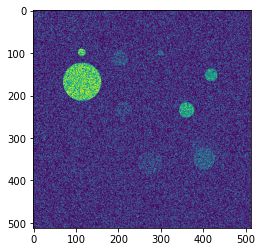

In [8]:
imshow(images[1])

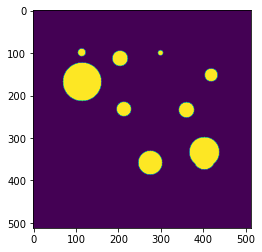

In [9]:
imshow(masks[1])

In [10]:
print(images.max())

255


In [11]:
print(images.min())

0


In [12]:
print(masks.max())

True


In [13]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [14]:
R.setup_data(images, masks, dataset_size=10000, weights=weights)

Weights OK!


In [15]:
RUNS = 5

In [ ]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0
Testing the classifier...


2023-04-20 21:41:43.427821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-20 21:41:43.446993: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz
2023-04-20 21:41:43.902347: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-20 21:41:44.767511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-20 21:41:45.811843: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-20 21:41:45.811867: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-20 21:41:45.812225: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modif

In [15]:
R.classifier_scores

[344.25732421875,
 348.4939880371094,
 346.9913330078125,
 347.586669921875,
 347.3193359375]

In [16]:
R.discriminator_scores

[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

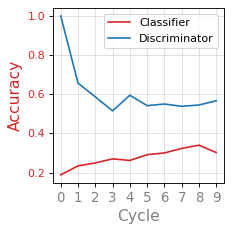

In [18]:
R.plot()

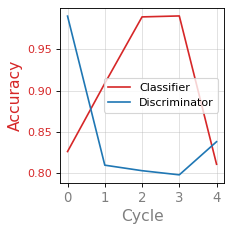

In [17]:
R.plot()